In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/tambet/.conda/envs/pommer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [3]:
data = np.load('single_600K_disc0.9.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((600000, 11, 11, 18), (600000,), (600000,))

In [4]:
data = np.load('valid_single_80K_disc0.9.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((80000, 11, 11, 18), (80000,), (80000,))

In [5]:
c = x = Input(shape=(11,11,18))
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
c = Conv2D(filters=256, kernel_size=3, strides=1, activation="relu", padding="same")(c)
h = Flatten()(c)
#h = Dense(128, activation='relu')(h)
p = Dense(6, activation="softmax", name='p')(h)
#h = Dense(128, activation='relu')(h)
v = Dense(1, activation="tanh", name='v')(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 256)  41728       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 11, 11, 256)  590080      conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 11, 11, 256)  590080      conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [6]:
callbacks = [
    ModelCheckpoint('conv256_single_value10_disc0.9_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
]

In [7]:
history = model.fit(x_train, [p_train, v_train], batch_size=512, epochs=100, validation_data=(x_test, [p_test, v_test]), callbacks=callbacks)

Train on 600000 samples, validate on 80000 samples
Epoch 1/100
600000/600000 [==============================] - 309s 515us/step - loss: 0.7699 - p_loss: 0.5431 - v_loss: 0.0227 - p_acc: 0.7452 - val_loss: 0.7625 - val_p_loss: 0.5358 - val_v_loss: 0.0227 - val_p_acc: 0.7461

Epoch 00002: val_loss improved from 0.85635 to 0.76248, saving model to conv256_single_value10_disc0.9_best.h5
Epoch 3/100
600000/600000 [==============================] - 306s 509us/step - loss: 0.7170 - p_loss: 0.5048 - v_loss: 0.0212 - p_acc: 0.7578 - val_loss: 0.7286 - val_p_loss: 0.5069 - val_v_loss: 0.0222 - val_p_acc: 0.7541

Epoch 00003: val_loss improved from 0.76248 to 0.72860, saving model to conv256_single_value10_disc0.9_best.h5
Epoch 4/100
450560/600000 [=====================>........] - ETA: 1:16 - loss: 0.6870 - p_loss: 0.4857 - v_loss: 0.0201 - p_acc: 0.7660

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5,1,'Value MSE')

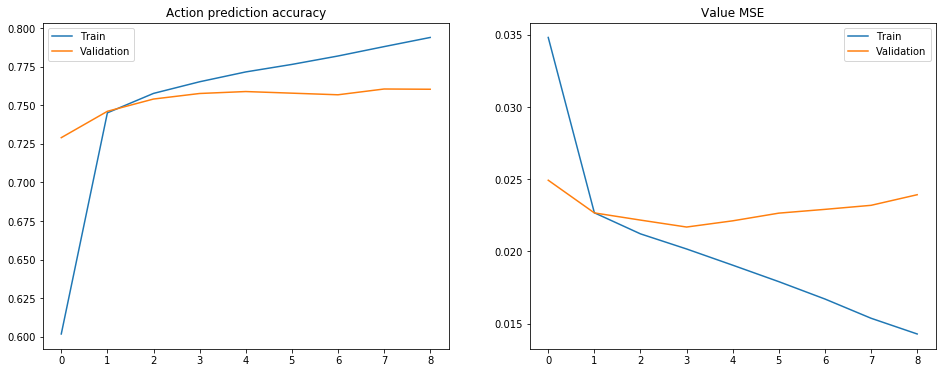

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [9]:
model.save('conv256_single_value10_disc0.9_final.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test, batch_size=2048)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.8068833333333333
Accuracy test: 0.76045
Explained variance train: 0.7716895221098755
Explained variance test: 0.5586517951072697


In [10]:
model = load_model('conv256_single_value10_disc0.9_best.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test, batch_size=2048)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.77554
Accuracy test: 0.7577
Explained variance train: 0.6622767901056521
Explained variance test: 0.6005532351810399
